# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from bs4 import BeautifulSoup

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,auc,roc_curve,classification_report,precision_score,recall_score,f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from prettytable import PrettyTable

from sklearn.linear_model import LogisticRegression

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

D:\Continuum\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
D:\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\Study_materials\Applied_AI\Assignments\database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (525814, 10)


In [3]:
sample_data = filtered_data.head(350000)

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(256438, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

73.268

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(256436, 10)


1    215863
0     40573
Name: Score, dtype: int64

In [ ]:
final.head()

#  [3] Preprocessing

In [9]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with 

In [10]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"she's", 't', 'no', 'nor', 'just', 'weren', 'where', "shan't", 'out', 'him', "needn't", "you'll", 'hers', 'd', 'y', 'now', 'are', 'but', 'couldn', 'for', 'when', 'we', 'you', 'these', 'more', "wasn't", 'too', 'll', 'under', 'yourselves', 'were', 'why', 'an', 'about', 'once', 'be', 'ain', "should've", 'above', 'then', 'by', 'our', 'than', 'wouldn', 'mustn', 'herself', 'they', 'other', 'shan', "shouldn't", 'do', 'each', 'any', 'hadn', 'it', 'ourselves', 'not', 'she', 'having', 'own', 'yourself', 'being', 'had', 'same', 'over', "mightn't", 'am', 'aren', 'your', "mustn't", 'my', 'a', 'hasn', 'if', 'm', 'between', "haven't", 're', "hadn't", 'while', 'have', 'up', "isn't", "it's", 'myself', 'the', 'shouldn', 'those', 'most', "don't", "won't", 'of', 'isn', 'so', 'again', 'theirs', 'because', 'mightn', 'only', 'themselves', 'before', "weren't", 'them', "couldn't", 'has', 'down', 'whom', "didn't", 'itself', 'which', 'can', "aren't", "you've", 'at', 'how', 'with', 'who', 'from', 'such', 'haven'

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

100%|█████████████████████████████████████████████████████████████████████████| 256436/256436 [06:42<00:00, 636.69it/s]


In [17]:
final = final.sort_values('Time',axis = 0,ascending = True, inplace = False, kind = 'quicksort', na_position='last')

In [19]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [21]:
X  = final['CleanedText'].values
y = final['Score']

In [22]:
# Creating training, test and cross validation set

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train,y_train, test_size = 0.3, random_state=0) 

In [23]:
print("Size of X_train and y_train:", X_train.shape,y_train.shape)
print("Size of X_test and y_test:", X_test.shape,y_test.shape)
print("Size of X_tr and y_tr:", X_tr.shape,y_tr.shape)
print("Size of X_cv and y_cv:", X_cv.shape,y_cv.shape)

Size of X_train and y_train: (179505,) (179505,)
Size of X_test and y_test: (76931,) (76931,)
Size of X_tr and y_tr: (125653,) (125653,)
Size of X_cv and y_cv: (53852,) (53852,)


## Building Training Model:

In [24]:
# Logistic regression with L1 regularization

def logistic_l1(X_train, X_cv, y_train, y_cv, c):
    best_c = c
    logl1 = LogisticRegression(penalty='l1', C = best_c)
    logl1.fit(X_train,y_train)
    pred_cv = logl1.predict(X_cv)
    pred_train = logl1.predict(X_train)
    probs_cv = logl1.predict_proba(X_cv)[:,1]
    probs_train = logl1.predict_proba(X_train)[:,1]
    auc_sc_cv = roc_auc_score(y_cv,probs_cv)
    auc_sc_train = roc_auc_score(y_train,probs_train)
    
    train_accl1 = accuracy_score(y_train,pred_train)*100
    cv_accl1 = accuracy_score(y_cv,pred_cv)*100
    precision_trainl1 = precision_score(y_train,pred_train)*100
    precision_cvl1 = precision_score(y_cv,pred_cv)*100
    recall_trainl1 = recall_score(y_train,pred_train)*100
    recall_cvl1 = recall_score(y_cv,pred_cv)*100
    f1_trainl1 = f1_score(y_train,pred_train)*100
    f1_cvl1 = f1_score(y_cv,pred_cv)*100
    
    print('Accuracy on Train data:',train_accl1)
    print('Precision on Train data:',precision_trainl1)
    print('Recall on Train data:',recall_trainl1)
    print('-'*30)
    print('Accuracy on CV data:',cv_accl1)
    print('Precision on CV data:',precision_cvl1)
    print('Recall on CV data:',recall_cvl1)
    print('-'*30)
    print('ROC curve for Training data:')
    print('='*30)
    fpr, tpr, thresholds = roc_curve(y_train,probs_train)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Train Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    
    print('-'*30)
    print('ROC curve for CV data:')
    print('='*30)
    fpr1, tpr1, thresholds1 = roc_curve(y_cv,probs_cv)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr1, tpr1, marker='.')
    plt.title("Line Plot of ROC Curve on CV Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    
    print('='*30)
    print('Plotting Confusion matrix, Precision Matrix and Recall Matrix for Train Data:')
    
    C1 = confusion_matrix(y_train, pred_train)
    
    A1 =(((C1.T)/(C1.sum(axis=1))).T)
    
    
    B1 =(C1/C1.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    #representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C1, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B1, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    #representing B in heatmap format
    sns.heatmap(A1, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()
    
    print('='*30)
    print('Plotting Confusion matrix, Precision Matrix and Recall Matrix for CV Data:')
    
    C2 = confusion_matrix(y_cv, pred_cv)
    
    A2 =(((C2.T)/(C2.sum(axis=1))).T)
    
    
    B2 =(C2/C2.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    #representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    #representing B in heatmap format
    sns.heatmap(A2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

In [25]:
# Logistic regression with L2 regularization

def logistic_l2(X_train, X_cv, y_train, y_cv, c):
    best_c = c
    logl2 = LogisticRegression(penalty='l2', C = best_c)
    logl2.fit(X_train,y_train)
    pred_cv = logl2.predict(X_cv)
    pred_train = logl2.predict(X_train)
    probs_cv = logl2.predict_proba(X_cv)[:,1]
    probs_train = logl2.predict_proba(X_train)[:,1]
    auc_sc_cv = roc_auc_score(y_cv,probs_cv)
    auc_sc_train = roc_auc_score(y_train,probs_train)
    
    train_accl2 = accuracy_score(y_train,pred_train)*100
    cv_accl2 = accuracy_score(y_cv,pred_cv)*100
    precision_trainl2 = precision_score(y_train,pred_train)*100
    precision_cvl2 = precision_score(y_cv,pred_cv)*100
    recall_trainl2 = recall_score(y_train,pred_train)*100
    recall_cvl2 = recall_score(y_cv,pred_cv)*100
    f1_trainl2 = f1_score(y_train,pred_train)*100
    f1_cvl2 = f1_score(y_cv,pred_cv)*100
    
    print('Accuracy on Train data:',train_accl2)
    print('Precision on Train data:',precision_trainl2)
    print('Recall on Train data:',recall_trainl2)
    print('-'*30)
    print('Accuracy on CV data:',cv_accl2)
    print('Precision on CV data:',precision_cvl2)
    print('Recall on CV data:',recall_cvl2)
    print('-'*30)
    print('ROC curve for Training data:')
    print('='*30)
    fpr, tpr, thresholds = roc_curve(y_train,probs_train)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Train Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    
    print('-'*30)
    print('ROC curve for CV data:')
    print('='*30)
    fpr1, tpr1, thresholds1 = roc_curve(y_cv,probs_cv)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr1, tpr1, marker='.')
    plt.title("Line Plot of ROC Curve on CV Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    
    print('='*30)
    print('Plotting Confusion matrix, Precision Matrix and Recall Matrix for Train Data:')
    
    C1 = confusion_matrix(y_train, pred_train)
    
    A1 =(((C1.T)/(C1.sum(axis=1))).T)
    
    
    B1 =(C1/C1.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    #representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C1, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B1, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    #representing B in heatmap format
    sns.heatmap(A1, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()
    
    print('='*30)
    print('Plotting Confusion matrix, Precision Matrix and Recall Matrix for CV Data:')
    
    C2 = confusion_matrix(y_cv, pred_cv)
    
    A2 =(((C2.T)/(C2.sum(axis=1))).T)
    
    
    B2 =(C2/C2.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    #representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    #representing B in heatmap format
    sns.heatmap(A2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

## Testing Model:

In [26]:
# Logistic regression model validation with L1 regularization

def testing_l1(X_train, y_train, X_test, y_test, c):
    best_c = c
    logl1 = LogisticRegression(penalty='l1', C = best_c)
    logl1.fit(X_train,y_train)
    pred = logl1.predict(X_test)
    pred_probs = logl1.predict_proba(X_test)[:,1]
    auc_sc_test = roc_auc_score(y_test,pred_probs)
    
    accl1 = accuracy_score(y_test,pred)*100
    precision_testl1 = precision_score(y_test,pred)*100
    recall_testl1 = recall_score(y_test,pred)*100
    f1_testl1 = f1_score(y_test,pred)*100
    
    print('Accuracy on Test data:',accl1)
    print('Precision on Test data:',precision_testl1)
    print('Recall on Test data:',recall_testl1)
    print('-'*30)
    
    print('ROC curve for Test data:')
    print('='*30)
    fpr, tpr, thresholds = roc_curve(y_test,pred_probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    
    print('='*30)
    print('Plotting Confusion matrix, Precision Matrix and Recall Matrix for Test Data:')
    
    C1 = confusion_matrix(y_test, pred)
    
    A1 =(((C1.T)/(C1.sum(axis=1))).T)
    
    
    B1 =(C1/C1.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    #representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C1, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B1, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    #representing B in heatmap format
    sns.heatmap(A1, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

In [27]:
# Logistic regression model validation with L2 regularization

def testing_l2(X_train, y_train, X_test, y_test, c):
    best_c = c
    logl2 = LogisticRegression(penalty='l2', C = best_c)
    logl2.fit(X_train,y_train)
    pred = logl2.predict(X_test)
    pred_probs = logl2.predict_proba(X_test)[:,1]
    auc_sc_test = roc_auc_score(y_test,pred_probs)
    
    accl2 = accuracy_score(y_test,pred)*100
    precision_testl2 = precision_score(y_test,pred)*100
    recall_testl2 = recall_score(y_test,pred)*100
    f1_testl2 = f1_score(y_test,pred)*100
    
    print('Accuracy on Test data:',accl2)
    print('Precision on Test data:',precision_testl2)
    print('Recall on Test data:',recall_testl2)
    print('-'*30)
    
    print('ROC curve for Test data:')
    print('='*30)
    fpr, tpr, thresholds = roc_curve(y_test,pred_probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    
    print('='*30)
    print('Plotting Confusion matrix, Precision Matrix and Recall Matrix for Test Data:')
    
    C2 = confusion_matrix(y_test, pred)
    
    A2 =(((C2.T)/(C2.sum(axis=1))).T)
    
    
    B2 =(C2/C2.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    #representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    #representing B in heatmap format
    sns.heatmap(A2, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

## Top 10 Features:

In [28]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def imp_feature(vectorizer,classifier, n =10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(classifier.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))


## 1. Bag of Words implementation:

In [29]:
count_vec = CountVectorizer(min_df=50)
BOW_X_train = count_vec.fit_transform(X_tr)
BOW_X_cv = count_vec.transform(X_cv)
BOW_X_test = count_vec.transform(X_test)

In [30]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
BOW_X_train_sc = sc.fit_transform(BOW_X_train)
BOW_X_cv_sc = sc.transform(BOW_X_cv)
BOW_X_test_sc = sc.transform(BOW_X_test)

D:\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 1.1 GridSearchCV with L1 regularization:

In [31]:
C = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]

In [32]:
tuning_param = {'C':C}
grid = GridSearchCV(LogisticRegression(penalty = 'l2'),param_grid = tuning_param,scoring = 'roc_auc',cv = 5,n_jobs = -1, pre_dispatch=2)
grid.fit(BOW_X_train_sc,y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [33]:
C1 = grid.best_estimator_.C
print('The Optimal tuning parameter C:',C1)

The Optimal tuning parameter C: 0.001


Accuracy on Train data: 88.58841412461302
Precision on Train data: 88.6887005315508
Recall on Train data: 99.0991671545391
------------------------------
Accuracy on CV data: 84.05073163485108
Precision on CV data: 84.04806567241796
Recall on CV data: 100.0
------------------------------
ROC curve for Training data:


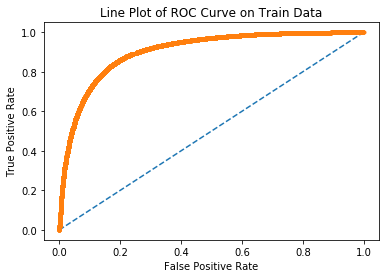

------------------------------
ROC curve for CV data:


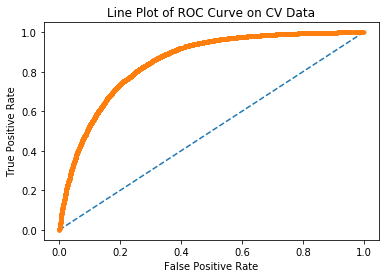

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Train Data:


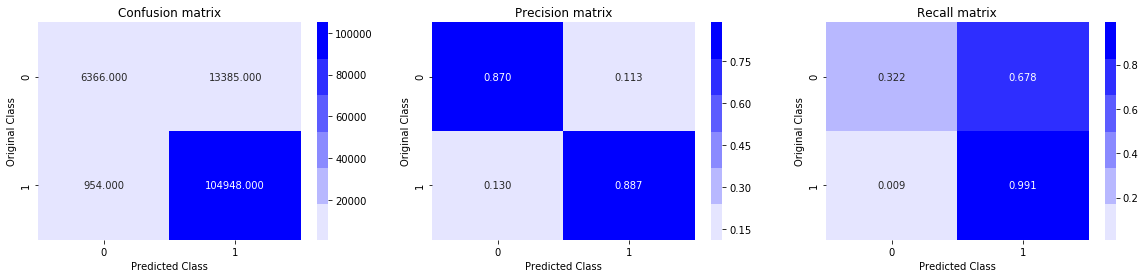

Plotting Confusion matrix, Precision Matrix and Recall Matrix for CV Data:


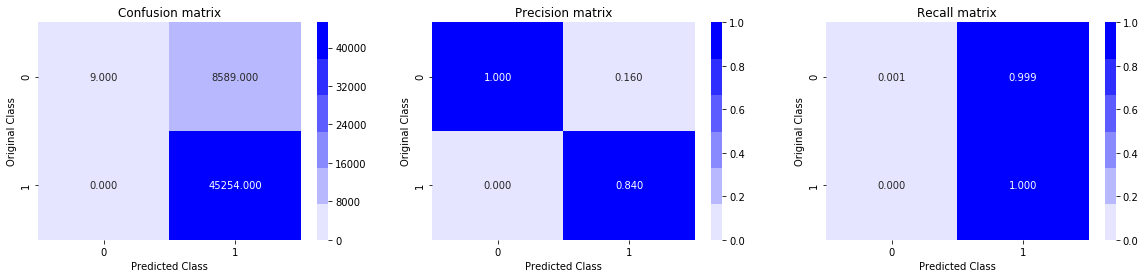

In [34]:
#Creating Logistic regression model with optimal C and L1 regularization

logistic_l1(BOW_X_train_sc,BOW_X_cv,y_tr,y_cv,C1)

Accuracy on Test data: 88.36229868323564
Precision on Test data: 88.50414364640883
Recall on Test data: 99.02638045342853
------------------------------
ROC curve for Test data:


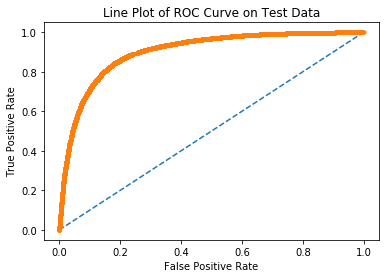

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Test Data:


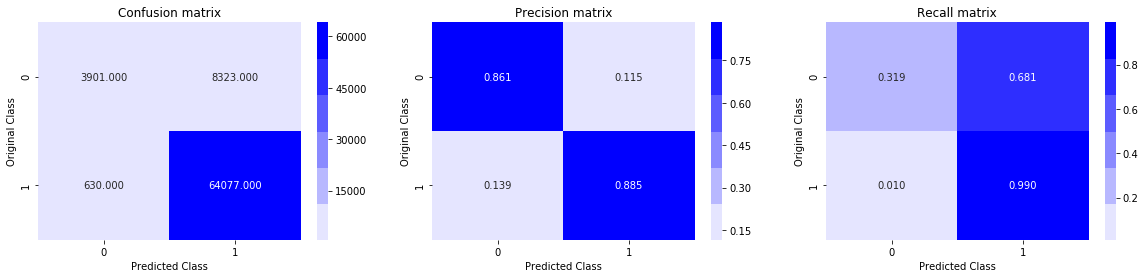

In [35]:
# Validation on test data

testing_l1(BOW_X_train_sc, y_tr, BOW_X_test_sc, y_test, C1)

In [36]:
#top 10 important feature for l1 regularization

clf1 = LogisticRegression(penalty='l1',C=C1)
clf1.fit(BOW_X_train_sc,y_tr)
imp_feature(count_vec,clf1)

			Negative						Positive
________________________________________________________________________________________________
	-0.2511	disappoint     				0.4885	great          
	-0.1502	return         				0.3498	love           
	-0.1423	worst          				0.2876	best           
	-0.1341	aw             				0.2454	delici         
	-0.1293	bad            				0.2010	good           
	-0.1247	terribl        				0.2005	perfect        
	-0.1202	horribl        				0.1558	excel          
	-0.1087	money          				0.1538	favorit        
	-0.1051	wast           				0.1296	nice           
	-0.0979	unfortun       				0.1029	easi           


## 1.2 GridSearchCV with L2 regularization:

In [37]:
grid1 = GridSearchCV(LogisticRegression(penalty = 'l1'),param_grid = tuning_param,scoring = 'roc_auc',cv = 5,n_jobs = -1, pre_dispatch=2)
grid1.fit(BOW_X_train_sc,y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [38]:
C1 = grid1.best_estimator_.C
print('The Optimal tuning parameter C:',C1)

The Optimal tuning parameter C: 0.01


Accuracy on Train data: 93.31890205566123
Precision on Train data: 94.56810889378468
Recall on Train data: 97.68370757870484
------------------------------
Accuracy on CV data: 85.12961449899726
Precision on CV data: 85.01748711970215
Recall on CV data: 99.91161002342335
------------------------------
ROC curve for Training data:


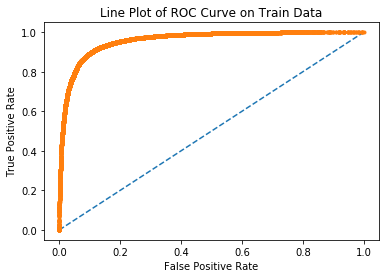

------------------------------
ROC curve for CV data:


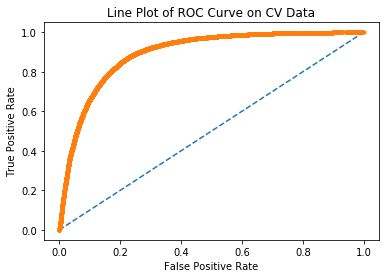

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Train Data:


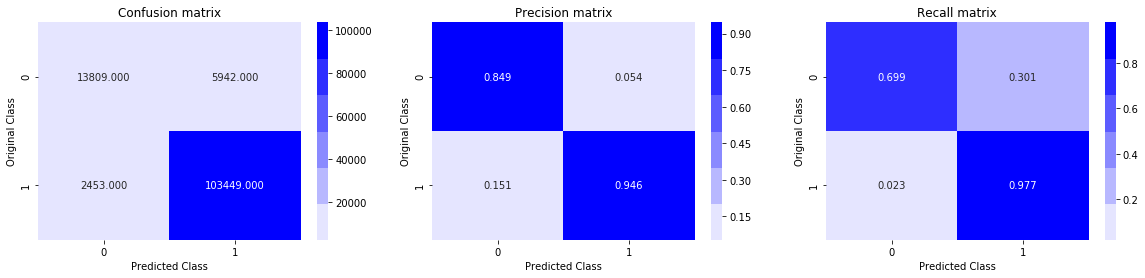

Plotting Confusion matrix, Precision Matrix and Recall Matrix for CV Data:


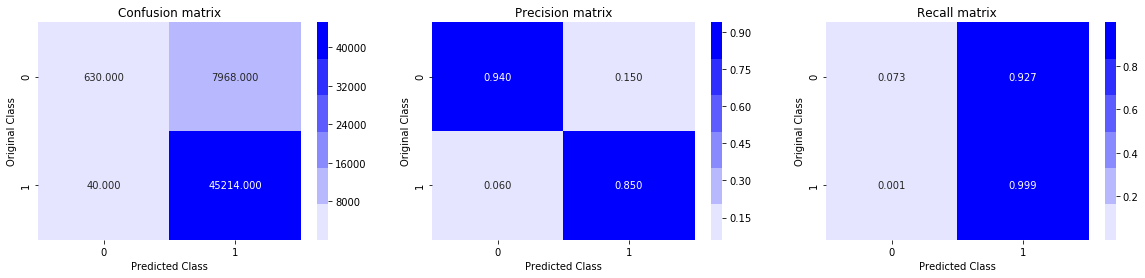

In [39]:
#Creating Logistic regression model with optimal C and L2 regularization

logistic_l2(BOW_X_train_sc,BOW_X_cv,y_tr,y_cv,C1)

Accuracy on Test data: 91.53657173311149
Precision on Test data: 93.57684128553029
Recall on Test data: 96.56605931352095
------------------------------
ROC curve for Test data:


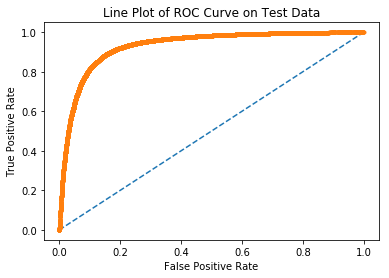

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Test Data:


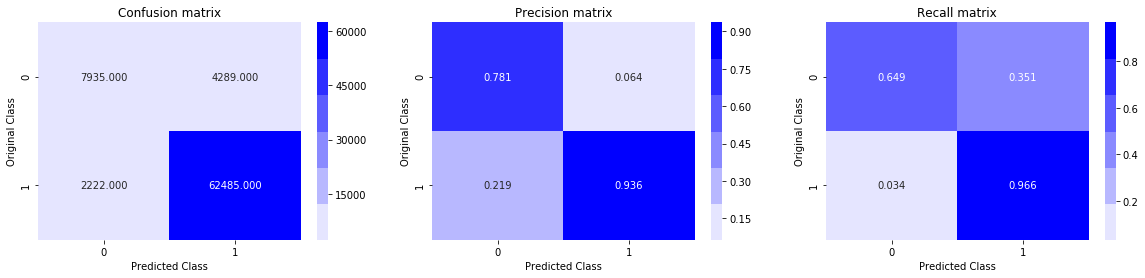

In [40]:
# Validation on test data

testing_l2(BOW_X_train_sc, y_tr, BOW_X_test_sc, y_test, C1)

In [41]:
#top 10 important feature for l2 regularization

clf2 = LogisticRegression(penalty='l2',C=C1)
clf2.fit(BOW_X_train_sc,y_tr)
imp_feature(count_vec,clf2)

			Negative						Positive
________________________________________________________________________________________________
	-0.3502	disappoint     				0.7325	great          
	-0.2446	worst          				0.5545	best           
	-0.2247	terribl        				0.5087	love           
	-0.2178	return         				0.5014	delici         
	-0.2169	tast           				0.4373	perfect        
	-0.2126	aw             				0.4094	excel          
	-0.1870	horribl        				0.4024	good           
	-0.1856	money          				0.2987	nice           
	-0.1745	unfortun       				0.2902	favorit        
	-0.1697	even           				0.2699	amaz           


### Pertubation Test on BoW

In [42]:
from scipy.sparse import find
logreg1 = LogisticRegression(C= C1, penalty= 'l2')
logreg1.fit(BOW_X_train_sc,y_tr)
weights1 = find(logreg1.coef_[0])[2]  #Weights before adding random noise
print("Non Zero weights:",np.count_nonzero(logreg1.coef_))

Non Zero weights: 4388


In [43]:
BOW_X_train_noise = BOW_X_train_sc.copy()
#Random noise
epsilon = np.random.uniform(low=-0.00001, high=0.00001, size=(find(BOW_X_train_noise)[0].size))
a,b,c = find(BOW_X_train_sc)
BOW_X_train_noise[a,b] = epsilon + BOW_X_train_sc[a,b]

In [44]:
logreg2 = LogisticRegression(C= C1, penalty= 'l2')
logreg2.fit(BOW_X_train_noise,y_tr)
print("Non Zero weights:",np.count_nonzero(logreg2.coef_))
weights2 = find(logreg2.coef_[0])[2]  #Weights after adding random noise

Non Zero weights: 4388


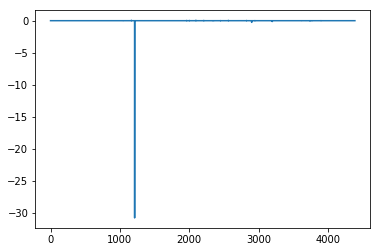

In [45]:
percentage_change_vec = (abs(weights1 - weights2)/weights1) * 100
plt.plot(percentage_change_vec)

In [46]:
print(percentage_change_vec[np.where(percentage_change_vec > 10)].size)

0


### Top 10 Collinear feature after Pertubation test

In [47]:
index = np.argsort(np.abs(weights1 - weights2))[::-1]
features = count_vec.get_feature_names()
features = np.array(features)
a = features[index]
print(a[:10])

['peterson' 'gari' 'rope' 'rubber' 'supper' 'wag' 'nong' 'riboflavin'
 'puck' 'destroy']


## 2. TF-IDF implementation:

In [48]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vec.fit_transform(X_tr)
tfidf_cv = tf_idf_vec.transform(X_cv)
tfidf_test = tf_idf_vec.transform(X_test)

print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
print("Size of CV dataset:", tfidf_cv.shape)
print("Size of test dataset:", tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (125653, 1471096)
Size of CV dataset: (53852, 1471096)
Size of test dataset: (76931, 1471096)


In [49]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
tfidf_train_sc = sc.fit_transform(tfidf_train)
tfidf_cv_sc = sc.transform(tfidf_cv)
tfidf_test_sc = sc.transform(tfidf_test)

## 2.1 GridSearchCV with L1 regularization:

In [50]:
grid2 = GridSearchCV(LogisticRegression(penalty = 'l1'),param_grid = tuning_param,scoring = 'roc_auc',cv = 5,n_jobs = -1, pre_dispatch=2)
grid2.fit(tfidf_train_sc,y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [51]:
C2 = grid2.best_estimator_.C
print('The Optimal tuning parameter C:',C2)

The Optimal tuning parameter C: 1


Accuracy on Train data: 99.99840831496265
Precision on Train data: 99.99811149720502
Recall on Train data: 100.0
------------------------------
Accuracy on CV data: 91.83688628091808
Precision on CV data: 92.75996316141996
Recall on CV data: 97.92946479869182
------------------------------
ROC curve for Training data:


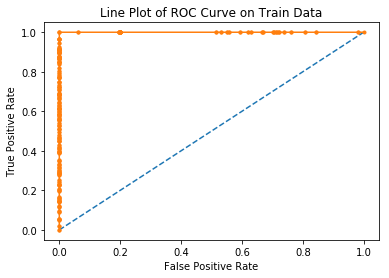

------------------------------
ROC curve for CV data:


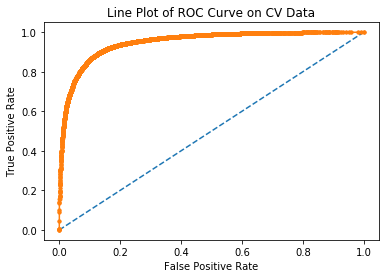

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Train Data:


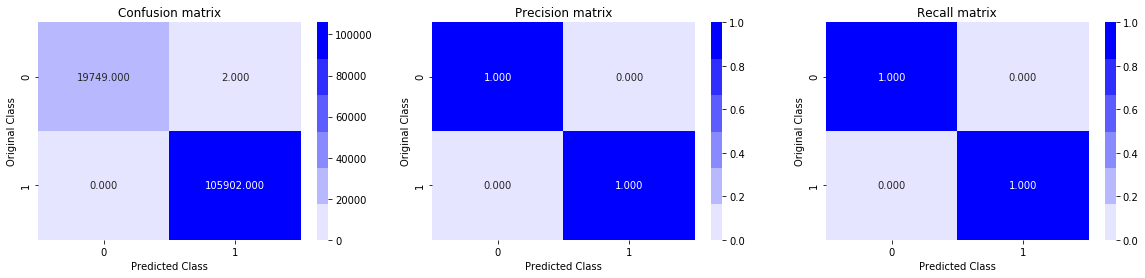

Plotting Confusion matrix, Precision Matrix and Recall Matrix for CV Data:


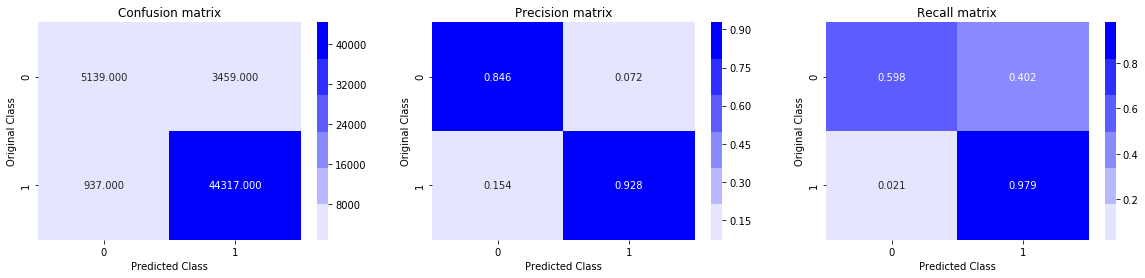

In [52]:
logistic_l1(tfidf_train_sc,tfidf_cv_sc,y_tr,y_cv,C2)

Accuracy on Test data: 91.91743250445205
Precision on Test data: 92.86101625360907
Recall on Test data: 97.91830868375911
------------------------------
ROC curve for Test data:


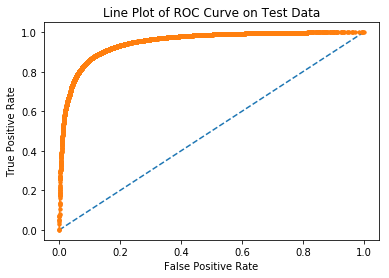

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Test Data:


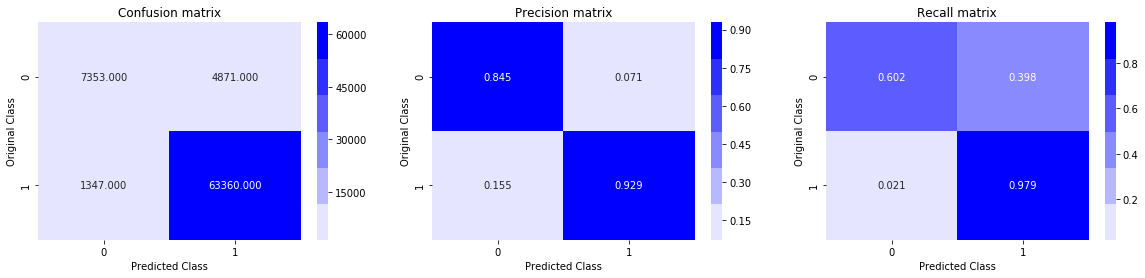

In [53]:
testing_l1(tfidf_train_sc, y_tr, tfidf_test_sc, y_test, C2)

In [54]:
#top 10 important feature for l1 regularization

clf3 = LogisticRegression(penalty='l1',C=C1)
clf3.fit(tfidf_train_sc,y_tr)
imp_feature(tf_idf_vec,clf3)

			Negative						Positive
________________________________________________________________________________________________
	-0.3899	disappoint     				0.8127	great          
	-0.2767	worst          				0.6019	love           
	-0.2522	return         				0.5822	best           
	-0.2280	terribl        				0.4822	delici         
	-0.2163	aw             				0.4013	good           
	-0.2058	horribl        				0.3800	perfect        
	-0.1729	stale          				0.3505	excel          
	-0.1666	threw          				0.3443	high recommend 
	-0.1535	two star       				0.2962	favorit        
	-0.1433	wont buy       				0.2712	nice           


## 2.2 GridSearchCV with L2 regularization:

In [55]:
grid3 = GridSearchCV(LogisticRegression(penalty = 'l2'),param_grid = tuning_param,scoring = 'roc_auc',cv = 5,n_jobs = -1, pre_dispatch=2)
grid3.fit(tfidf_train_sc,y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [56]:
C3 = grid3.best_estimator_.C
print('The Optimal tuning parameter C:',C3)

The Optimal tuning parameter C: 1000


Accuracy on Train data: 99.99840831496265
Precision on Train data: 99.99905573076995
Recall on Train data: 99.99905573076995
------------------------------
Accuracy on CV data: 89.19631582856718
Precision on CV data: 89.14631725233274
Recall on CV data: 99.22437795553985
------------------------------
ROC curve for Training data:


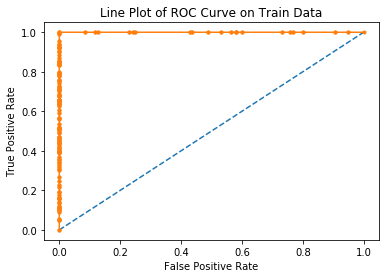

------------------------------
ROC curve for CV data:


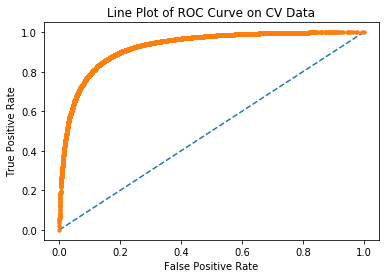

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Train Data:


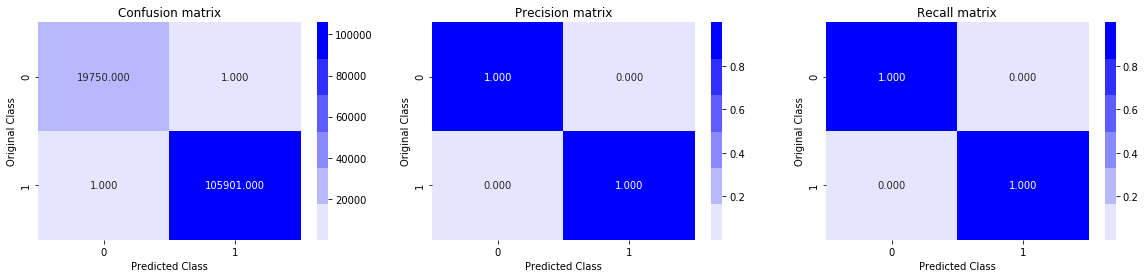

Plotting Confusion matrix, Precision Matrix and Recall Matrix for CV Data:


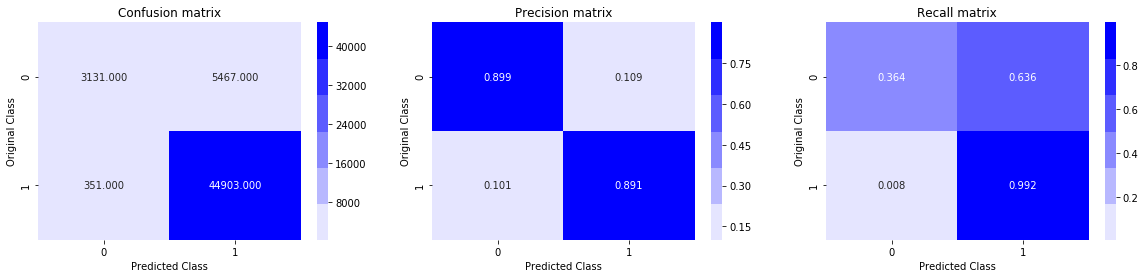

In [57]:
logistic_l2(tfidf_train_sc,tfidf_cv_sc,y_tr,y_cv,C3)

Accuracy on Test data: 89.32030000909906
Precision on Test data: 89.28934080761152
Recall on Test data: 99.20255922852242
------------------------------
ROC curve for Test data:


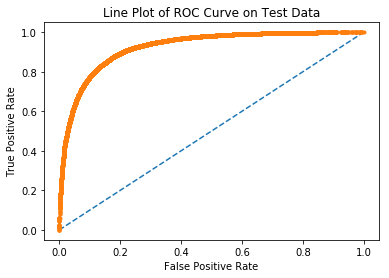

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Test Data:


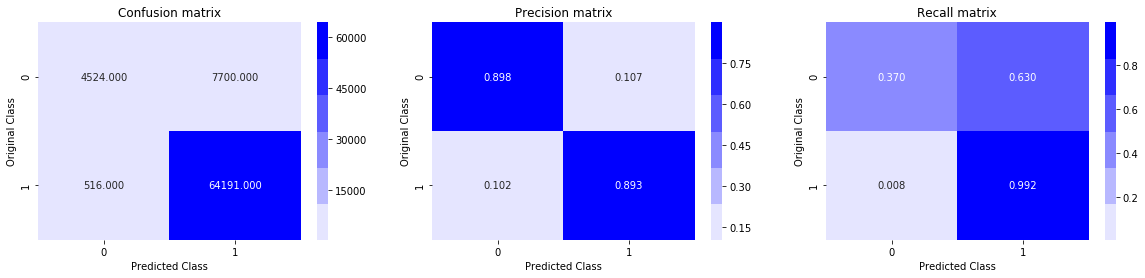

In [58]:
testing_l2(tfidf_train_sc, y_tr, tfidf_test_sc, y_test, C3)

In [59]:
#top 10 important feature for l2 regularization

clf4 = LogisticRegression(penalty='l2',C=C3)
clf4.fit(tfidf_train_sc,y_tr)
imp_feature(tf_idf_vec,clf4)

			Negative						Positive
________________________________________________________________________________________________
	-0.1022	disappoint     				0.2583	love           
	-0.0934	worst          				0.2560	great          
	-0.0799	wast money     				0.1990	good           
	-0.0790	aw             				0.1805	best           
	-0.0756	terribl        				0.1397	delici         
	-0.0731	return         				0.1270	excel          
	-0.0727	horribl        				0.1202	favorit        
	-0.0701	wast           				0.1136	use            
	-0.0646	stale          				0.1099	perfect        
	-0.0618	threw          				0.1071	find           


## Avg-W2V implementation:

In [60]:
i=0
list_sent_train=[]
for sent in X_tr:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_train.append(filtered_sentence)

In [61]:
i=0
list_sent_train1=[]
for sent in X_tr:
    filtered_sentence=[]
    sent=sent
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_train1.append(filtered_sentence)

In [63]:
i=0
list_sent_CV=[]
for sent in X_cv:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_CV.append(filtered_sentence)

In [64]:
i=0
list_sent_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_test.append(filtered_sentence)

In [65]:
import gensim
w2v_model = gensim.models.Word2Vec(list_sent_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [66]:
def avg_w2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [67]:
train_avgw2v = avg_w2v(list_sent_train)

125653
50


In [68]:
cv_avgw2v = avg_w2v(list_sent_CV)

53852
50


In [69]:
test_avgw2v = avg_w2v(list_sent_test)

76931
50


In [70]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
aw2v_X_train_sc = sc.fit_transform(train_avgw2v)
aw2v_X_cv_sc = sc.transform(cv_avgw2v)
aw2v_X_test_sc = sc.transform(test_avgw2v)

### 3.1 GridSearchCV with L1 regularization:

In [71]:
grid4 = GridSearchCV(LogisticRegression(penalty = 'l1'),param_grid = tuning_param,scoring = 'roc_auc',cv = 5,n_jobs = -1, pre_dispatch=2)
grid4.fit(aw2v_X_train_sc,y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [72]:
C4 = grid4.best_estimator_.C
print('The Optimal tuning parameter C:',C4)

The Optimal tuning parameter C: 10


Accuracy on Train data: 89.56809626511107
Precision on Train data: 91.35204991087345
Recall on Train data: 96.78476327170404
------------------------------
Accuracy on CV data: 89.24459630097303
Precision on CV data: 91.01055869637513
Recall on CV data: 96.75829760905114
------------------------------
ROC curve for Training data:


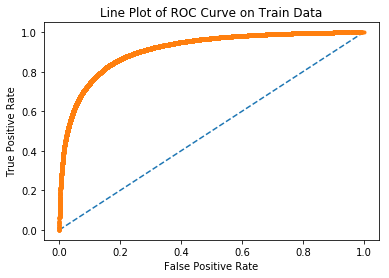

------------------------------
ROC curve for CV data:


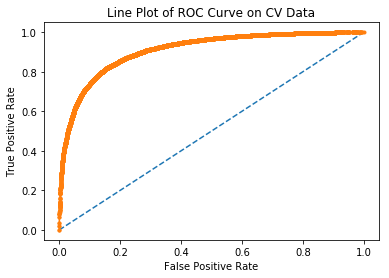

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Train Data:


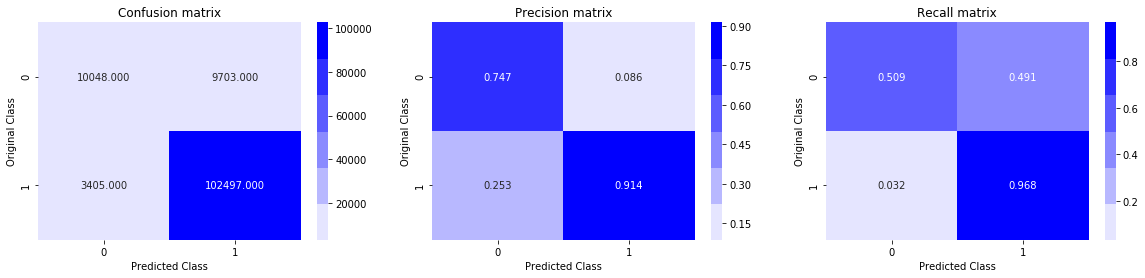

Plotting Confusion matrix, Precision Matrix and Recall Matrix for CV Data:


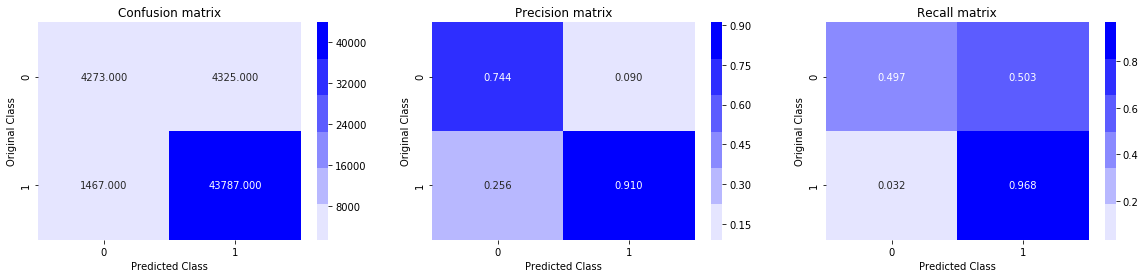

In [73]:
logistic_l1(aw2v_X_train_sc,aw2v_X_cv_sc,y_tr,y_cv,C4)

Accuracy on Test data: 89.33589840246454
Precision on Test data: 91.17874269389421
Recall on Test data: 96.67423926314001
------------------------------
ROC curve for Test data:


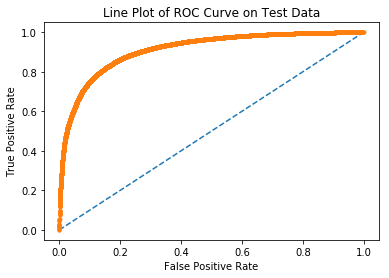

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Test Data:


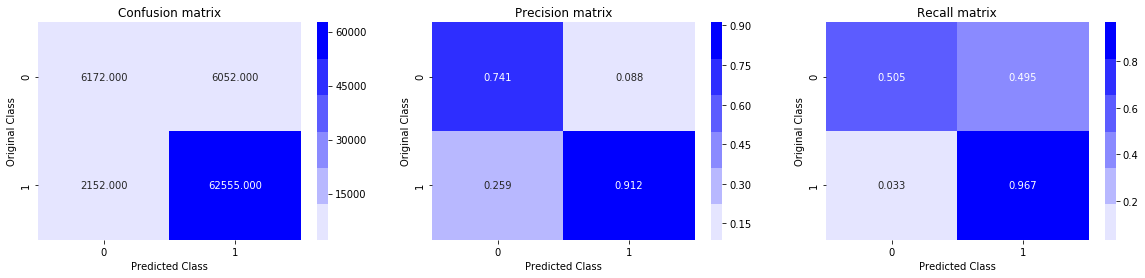

In [74]:
testing_l1(aw2v_X_train_sc, y_tr, aw2v_X_test_sc, y_test, C4)

### 3.2 GridSearchCV with L2 regularization:

In [75]:
grid5 = GridSearchCV(LogisticRegression(penalty = 'l2'),param_grid = tuning_param,scoring = 'roc_auc',cv = 5,n_jobs = -1, pre_dispatch=2)
grid5.fit(aw2v_X_train_sc,y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [76]:
C5 = grid5.best_estimator_.C
print('The Optimal tuning parameter C:',C5)

The Optimal tuning parameter C: 0.01


Accuracy on Train data: 89.55934199740555
Precision on Train data: 91.28422813715282
Recall on Train data: 96.86030481010745
------------------------------
Accuracy on CV data: 89.19817276981357
Precision on CV data: 90.91399522772072
Recall on CV data: 96.82238034206921
------------------------------
ROC curve for Training data:


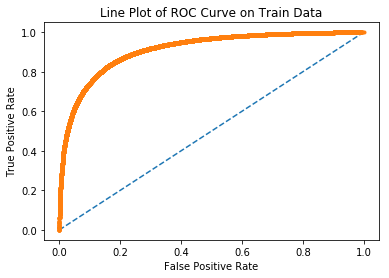

------------------------------
ROC curve for CV data:


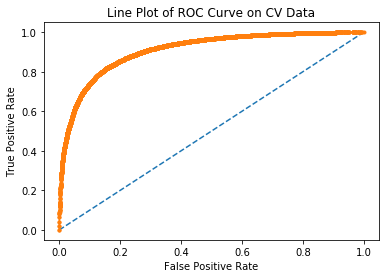

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Train Data:


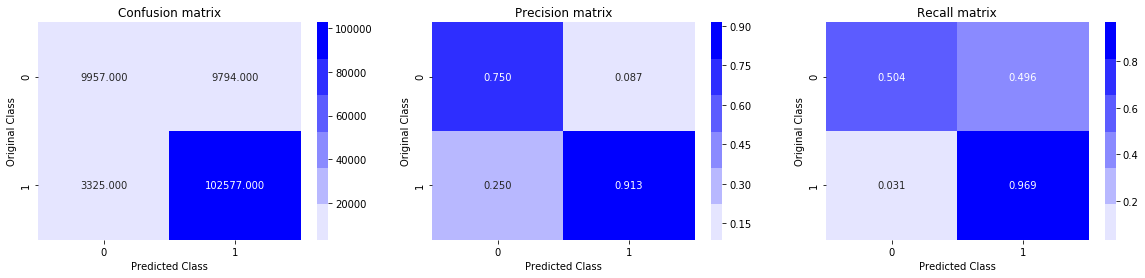

Plotting Confusion matrix, Precision Matrix and Recall Matrix for CV Data:


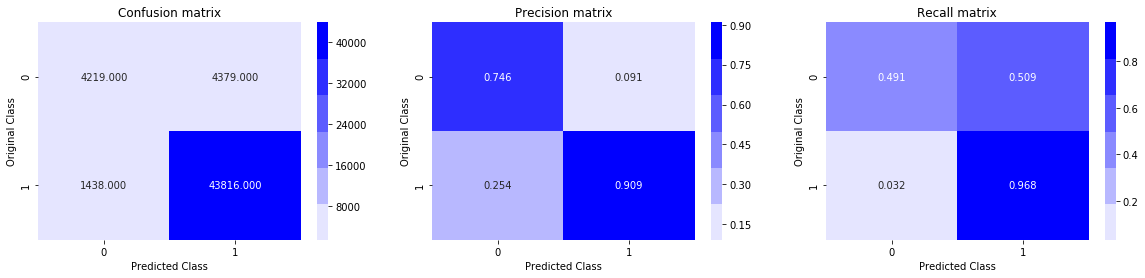

In [77]:
logistic_l2(aw2v_X_train_sc,aw2v_X_cv_sc,y_tr,y_cv,C5)

Accuracy on Test data: 89.3034017496198
Precision on Test data: 91.09762486901852
Recall on Test data: 96.73605637720803
------------------------------
ROC curve for Test data:


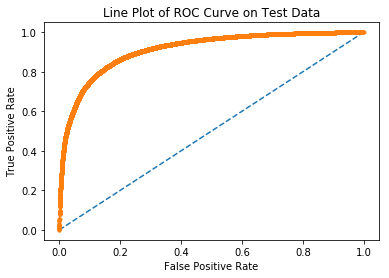

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Test Data:


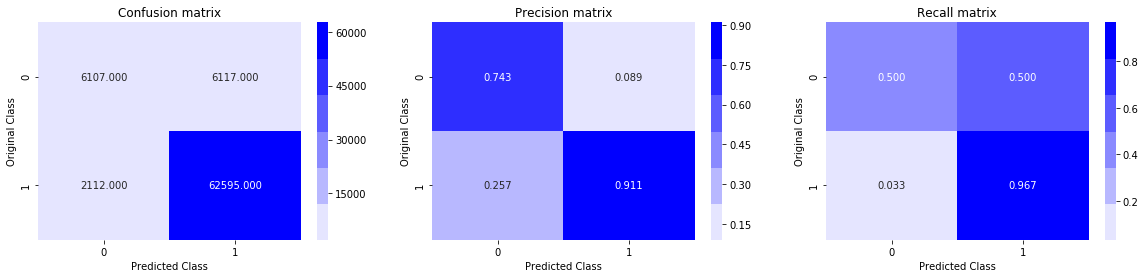

In [78]:
testing_l2(aw2v_X_train_sc, y_tr, aw2v_X_test_sc, y_test, C5)

## TF_IDF-W2V implementation:

In [79]:
tf_idf_vect = TfidfVectorizer()
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (125653, 42377)
CV Data Size:  (53852, 42377)
Test Data Size:  (76931, 42377)


In [82]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in tqdm(list_sent_train):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|████████████████████████████████████████████████████████████████████████| 125653/125653 [2:54:42<00:00, 11.99it/s]


125653
50


In [84]:
import time
start1 = time.clock()
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_sent_CV):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_cv[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_CV))
print(len(tfidf_sent_vectors_CV[0]))
print((time.clock()-start1)/60)

100%|██████████████████████████████████████████████████████████████████████████| 53852/53852 [1:11:53<00:00, 10.82it/s]


53852
50
71.9081481705877


In [85]:
start2 = time.clock()
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_sent_test):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
print((time.clock()-start1)/60)

100%|██████████████████████████████████████████████████████████████████████████| 76931/76931 [1:31:52<00:00, 13.96it/s]


76931
50
163.78396017093414


In [86]:
train_tfidfw2v = tfidf_sent_vectors_train
cv_tfidfw2v = tfidf_sent_vectors_CV
test_tfidfw2v = tfidf_sent_vectors_test

In [92]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
tfidfw2v_X_train_sc = sc.fit_transform(train_tfidfw2v)
tfidfw2v_X_cv_sc = sc.transform(cv_tfidfw2v)
tfidfw2v_X_test_sc = sc.transform(test_tfidfw2v)

### 4.1 GridSearchCV with L1 regularization:

In [93]:
grid6 = GridSearchCV(LogisticRegression(penalty = 'l1'),param_grid = tuning_param,scoring = 'roc_auc',cv = 5,n_jobs = -1, pre_dispatch=2)
grid6.fit(tfidfw2v_X_train_sc,y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [94]:
C6 = grid6.best_estimator_.C
print('The Optimal tuning parameter C:',C6)

The Optimal tuning parameter C: 0.1


Accuracy on Train data: 89.5704837926671
Precision on Train data: 91.34933295309729
Recall on Train data: 96.79137315631434
------------------------------
Accuracy on CV data: 89.24088241848028
Precision on CV data: 91.00677557467681
Recall on CV data: 96.75829760905114
------------------------------
ROC curve for Training data:


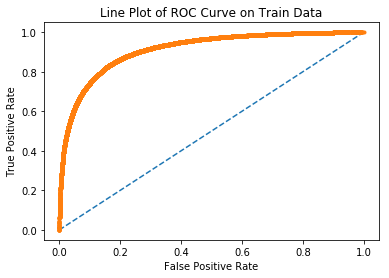

------------------------------
ROC curve for CV data:


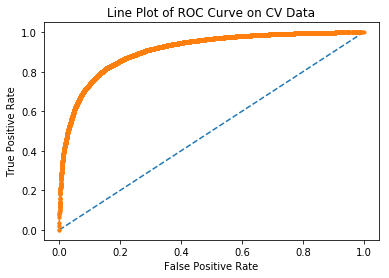

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Train Data:


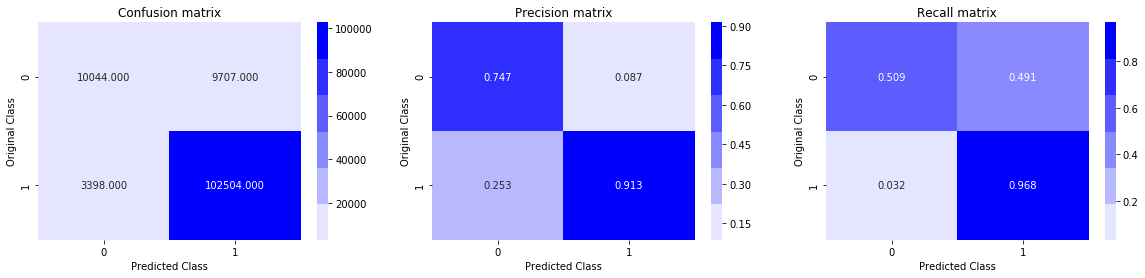

Plotting Confusion matrix, Precision Matrix and Recall Matrix for CV Data:


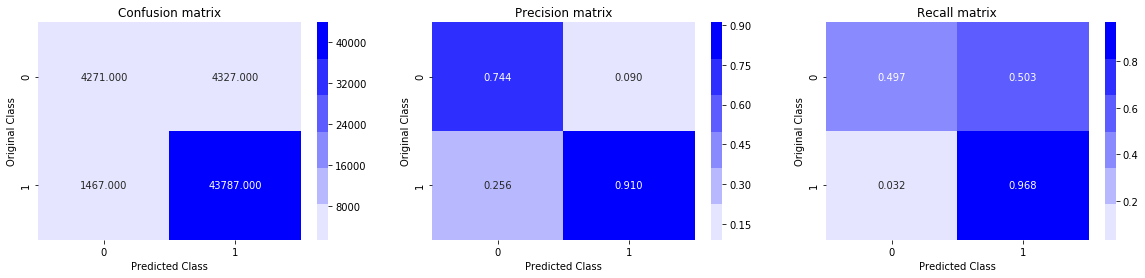

In [90]:
logistic_l1(tfidfw2v_X_train_sc,tfidfw2v_X_cv_sc,y_tr,y_cv,C6)

Accuracy on Test data: 89.33589840246454
Precision on Test data: 91.17874269389421
Recall on Test data: 96.67423926314001
------------------------------
ROC curve for Test data:


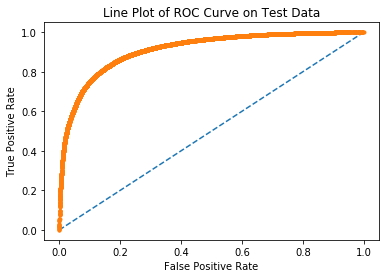

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Test Data:


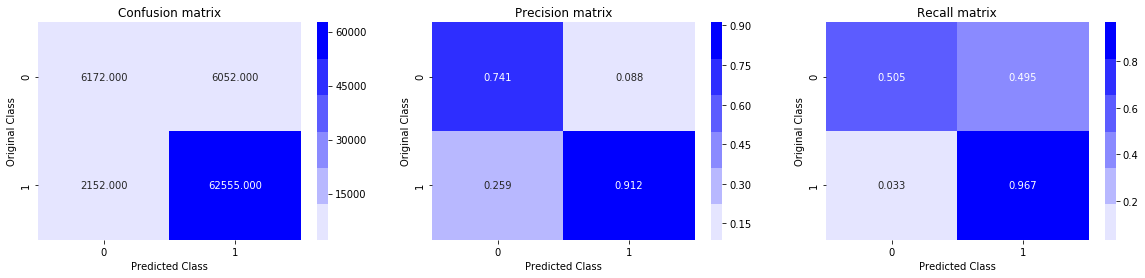

In [91]:
testing_l1(tfidfw2v_X_train_sc, y_tr, tfidfw2v_X_test_sc, y_test, C6)

### 4.2 GridSearchCV with L2 regularization:

In [95]:
grid7 = GridSearchCV(LogisticRegression(penalty = 'l2'),param_grid = tuning_param,scoring = 'roc_auc',cv = 5,n_jobs = -1, pre_dispatch=2)
grid7.fit(tfidfw2v_X_train_sc,y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch=2, refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [96]:
C7 = grid7.best_estimator_.C
print('The Optimal tuning parameter C:',C7)

The Optimal tuning parameter C: 0.01


Accuracy on Train data: 88.14353815666955
Precision on Train data: 89.8092738407699
Recall on Train data: 96.93112500236067
------------------------------
Accuracy on CV data: 87.92616801604397
Precision on CV data: 89.55900367496938
Recall on CV data: 96.93286781279002
------------------------------
ROC curve for Training data:


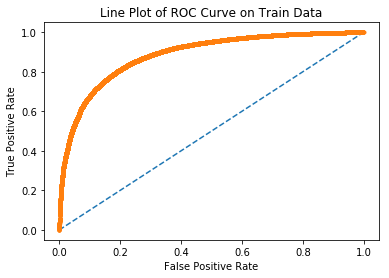

------------------------------
ROC curve for CV data:


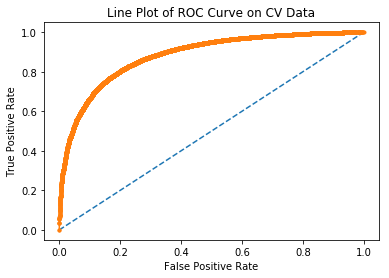

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Train Data:


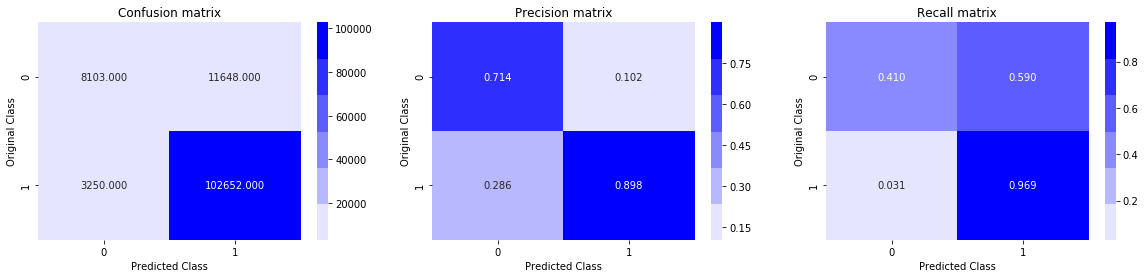

Plotting Confusion matrix, Precision Matrix and Recall Matrix for CV Data:


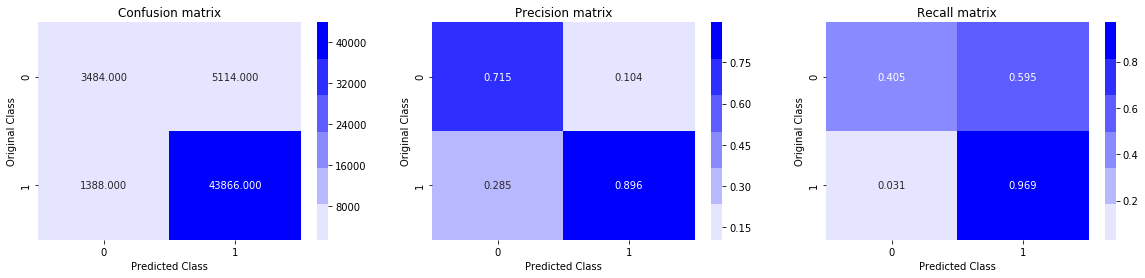

In [97]:
logistic_l2(tfidfw2v_X_train_sc,tfidfw2v_X_cv_sc,y_tr,y_cv,C7)

Accuracy on Test data: 87.99703630526055
Precision on Test data: 89.61395089763914
Recall on Test data: 96.96787055496314
------------------------------
ROC curve for Test data:


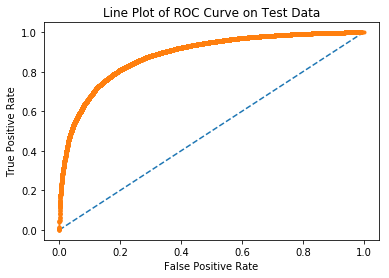

Plotting Confusion matrix, Precision Matrix and Recall Matrix for Test Data:


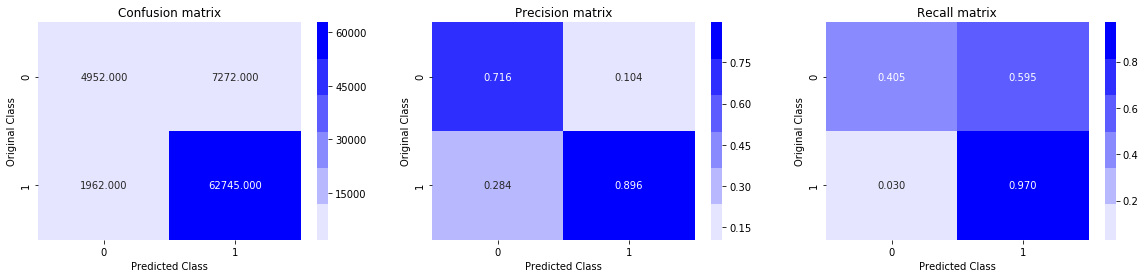

In [98]:
testing_l2(tfidfw2v_X_train_sc, y_tr, tfidfw2v_X_test_sc, y_test, C7)

In [103]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Regularization", "Best Hyper Parameter(C)","Test Accuracy","Precision","Recall"]
x.add_row(["BoW","L1",0.001,88.36,88.5,99.02])
x.add_row(["BoW","L2",0.01,91.53,93.57,96.56])
x.add_row(["Tf-Idf","L1",1,91.91,92.86,97.91])
x.add_row(["Tf-Idf","L2",1000,89.32,89.28,99.2])
x.add_row(["Avg-W2V","L1",10,89.33,91.17,96.67])
x.add_row(["Avg-W2V","L2",0.01,89.3,91.09,96.73])
x.add_row(["TfIdf-W2V","L1",1,89.33,91.17,96.67])
x.add_row(["TfIdf-W2V","L2",0.01,87.99,89.61,96.96])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+----------------+-------------------------+---------------+-----------+--------+
| Vectorizer | Regularization | Best Hyper Parameter(C) | Test Accuracy | Precision | Recall |
+------------+----------------+-------------------------+---------------+-----------+--------+
|    BoW     |       L1       |          0.001          |     88.36     |    88.5   | 99.02  |
|    BoW     |       L2       |           0.01          |     91.53     |   93.57   | 96.56  |
|   Tf-Idf   |       L1       |            1            |     91.91     |   92.86   | 97.91  |
|   Tf-Idf   |       L2       |           1000          |     89.32     |   89.28   |  99.2  |
|  Avg-W2V   |       L1       |            10           |     89.33     |   91.17   | 96.67  |
|  Avg-W2V   |       L2       |           0.01          |      89.3     |   91.09   | 96.73  |
| TfIdf-W2V  |       L1       |            1            |     89.33     |   91.17   | 96.67  |
| TfIdf-W2V  |       L2       |           0.01    